In [1]:
# If you are using SageMaker Notebook Instance:
# You need to do the following in order to run GPU-enabled Keras training.
# 1. Make sure you are in us-west-2 (Oregon) region.
# 2. Request service limit increase for ml.p2.xlarge instance type to 1.
# 3. Change the notebook instance type to a ml.p2.xlarge
# 4. Run this cell to install a required Python package.
!conda install -y pyarrow

# If you are using Google Colab:
# You need to do the following in order to run GPU-enabled Keras training.
# 1. Runtime -> Change runtime type -> Hardware accelerator -> GPU
# 2. Restart the kernel.

/bin/bash: conda: command not found


In [1]:
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if len(gpu_devices) == 1:
    print(f'Found {gpu_devices[0]}')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    raise Error('GPU was not found')

Found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [3]:
%%capture
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/storage/weather/jobs/transform_batch/20191012-224036_11821011c9a918e8d06e521c8606235e'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 4

In [4]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   humidity     826464 non-null  float64
 1   pressure     826464 non-null  float64
 2   temperature  826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 32.3+ MB


In [5]:
score_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57576 entries, ('Albuquerque/2249/0', Timestamp('2017-07-15 13:00:00')) to ('Vancouver/2623/10', Timestamp('2017-07-07 20:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   humidity     57576 non-null  float64
 1   pressure     57576 non-null  float64
 2   temperature  57576 non-null  float64
 3   wind_speed   57576 non-null  float64
dtypes: float64(4)
memory usage: 2.2+ MB


In [6]:
train_X.head()

humidity  pressure  temperature  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00      47.0    1031.0   276.323000   
                   2015-02-16 10:00:00      45.0    1032.0   275.097667   
                   2015-02-16 11:00:00      48.0    1032.0   273.931333   
                   2015-02-16 12:00:00      46.0    1033.0   274.380000   
                   2015-02-16 13:00:00      51.0    1033.0   272.675333   

                                        wind_speed  
sample             time                             
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  
                   2015-02-16 10:00:00         3.0  
                   2015-02-16 11:00:00         2.0  
                   2015-02-16 12:00:00         2.0  
                   2015-02-16 13:00:00         1.0

In [7]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [8]:
train_X.loc['Albuquerque/1112/1'].head()

,humidity,pressure,temperature,wind_speed
time,,,,
2015-02-20 18:00:00,46.0,1023.0,282.116500,3.0
2015-02-20 19:00:00,40.0,1021.0,287.061667,4.0
2015-02-20 20:00:00,38.0,1019.0,288.236333,4.0
2015-02-20 21:00:00,35.0,1020.0,286.928000,4.0
2015-02-20 22:00:00,34.0,1017.0,288.930333,5.0


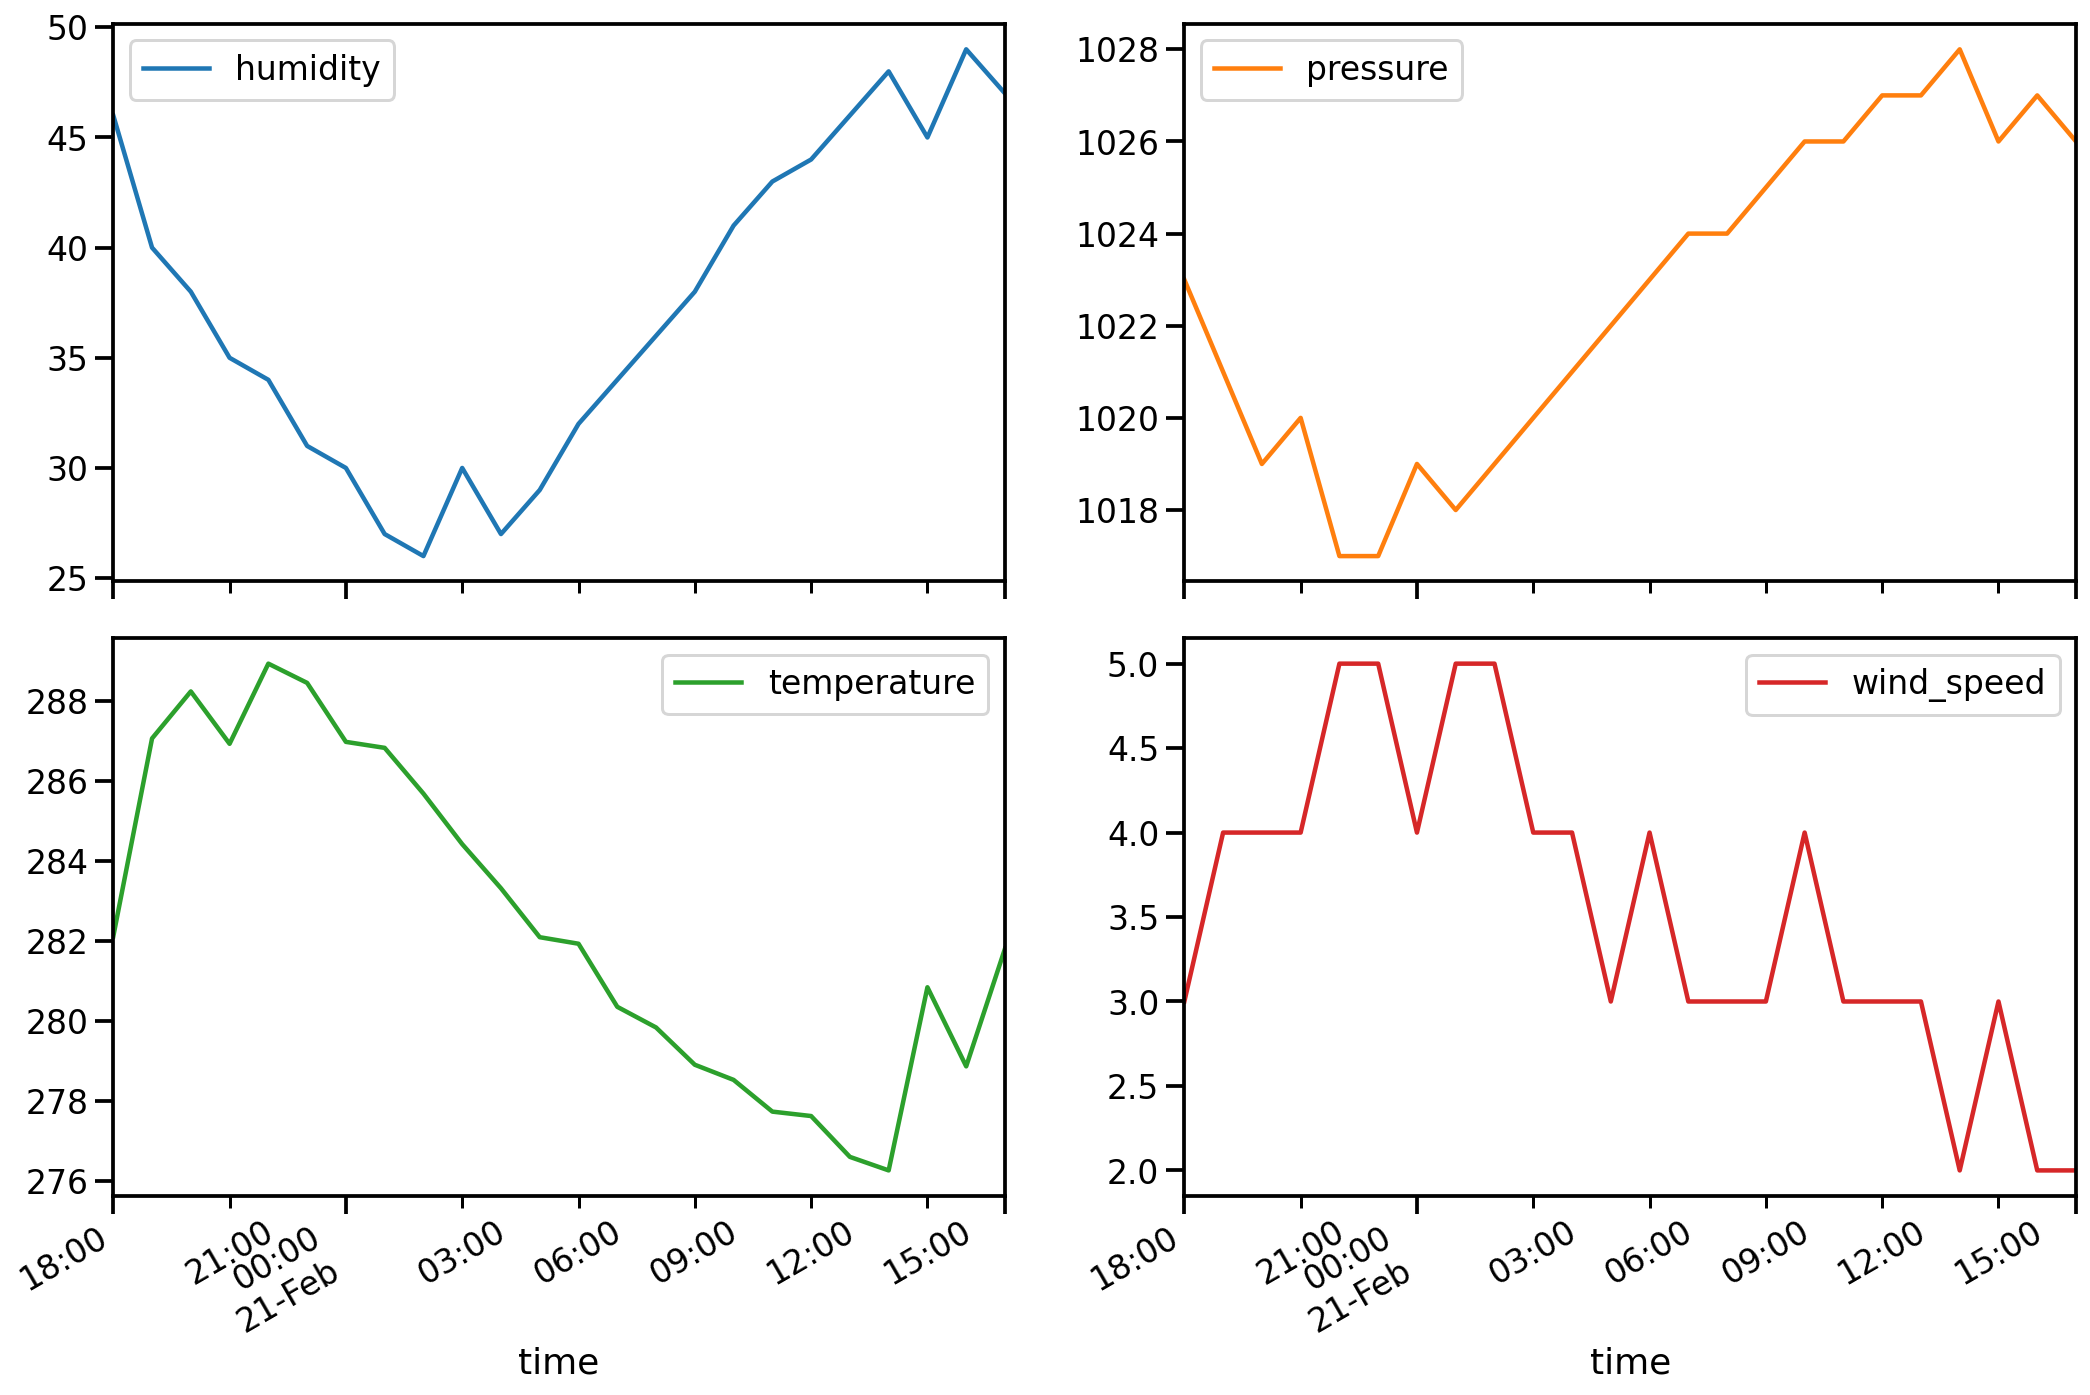

In [9]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

In [11]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)"


In [12]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.

In [13]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y']
)

,actual shape,expected shape
train_X,"(34436, 24, 4)","(34436, 24, 4)"
train_y,"(34436, 24)","(34436, 24)"
validate_X,"(2288, 24, 4)","(2288, 24, 4)"
validate_y,"(2288, 24)","(2288, 24)"


In [14]:
from tensorflow.python.keras.layers import Dense, CuDNNGRU, BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python import GlorotUniform

layers = [
        CuDNNGRU(
            input_shape=(condition_window, features_length),
            units=100,
            return_sequences=True,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        BatchNormalization(),
        CuDNNGRU(
            units=50,
            return_sequences=True,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        BatchNormalization(),
        CuDNNGRU(
            units=25,
            return_sequences=False,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            activation='linear'
        )
]

model = Sequential(layers)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru (CuDNNGRU)         (None, 24, 100)           31800     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 100)           400       
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 24, 50)            22800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 50)            200       
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 25)                5775      
_________________________________________________________________
batch_normalization_2 (Batch (None, 25)                100       
_________________________________________________________________
dense (Dense)                (None, 24)                6

In [16]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=0.01),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        r2_score,
        mean_error
    ]
)

In [17]:
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=20,
    batch_size=100,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

Epoch 1/20
345/345 [==============================] - 9s 25ms/step - loss: 32105.0391 - mean_absolute_error: 144.8926 - r2_score: -237.9011 - mean_error: -144.5269 - val_loss: 30.5282 - val_mean_absolute_error: 4.4095 - val_r2_score: 0.1915 - val_mean_error: 0.9242 - lr: 0.0100
Epoch 2/20
345/345 [==============================] - 3s 8ms/step - loss: 22.8736 - mean_absolute_error: 3.7644 - r2_score: 0.8301 - mean_error: -0.1382 - val_loss: 28.2429 - val_mean_absolute_error: 4.2106 - val_r2_score: 0.2695 - val_mean_error: 2.1759 - lr: 0.0100
Epoch 3/20
345/345 [==============================] - 3s 8ms/step - loss: 20.3889 - mean_absolute_error: 3.5416 - r2_score: 0.8483 - mean_error: -0.0077 - val_loss: 24.0875 - val_mean_absolute_error: 3.7641 - val_r2_score: 0.3820 - val_mean_error: 0.1345 - lr: 0.0100
Epoch 4/20
345/345 [==============================] - 3s 8ms/step - loss: 17.7870 - mean_absolute_error: 3.2870 - r2_score: 0.8674 - mean_error: -0.0137 - val_loss: 23.8500 - val_mean_a

In [20]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
#         batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

rnn_metrics

train                   validate                 
      MSE   MAE    R2    ME      MSE   MAE    R2   ME
rnn  9.56  2.29  0.42  0.33    18.23  3.18 -0.06  0.4

In [21]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

In [22]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(2)

train       validate      
              MSE    R2      MSE    R2
mean        26.77  0.80    37.23  0.58
constant    21.82  0.84    40.25  0.54
regression  30.53  0.78    29.94  0.66
rnn          9.56  0.42    18.23 -0.06

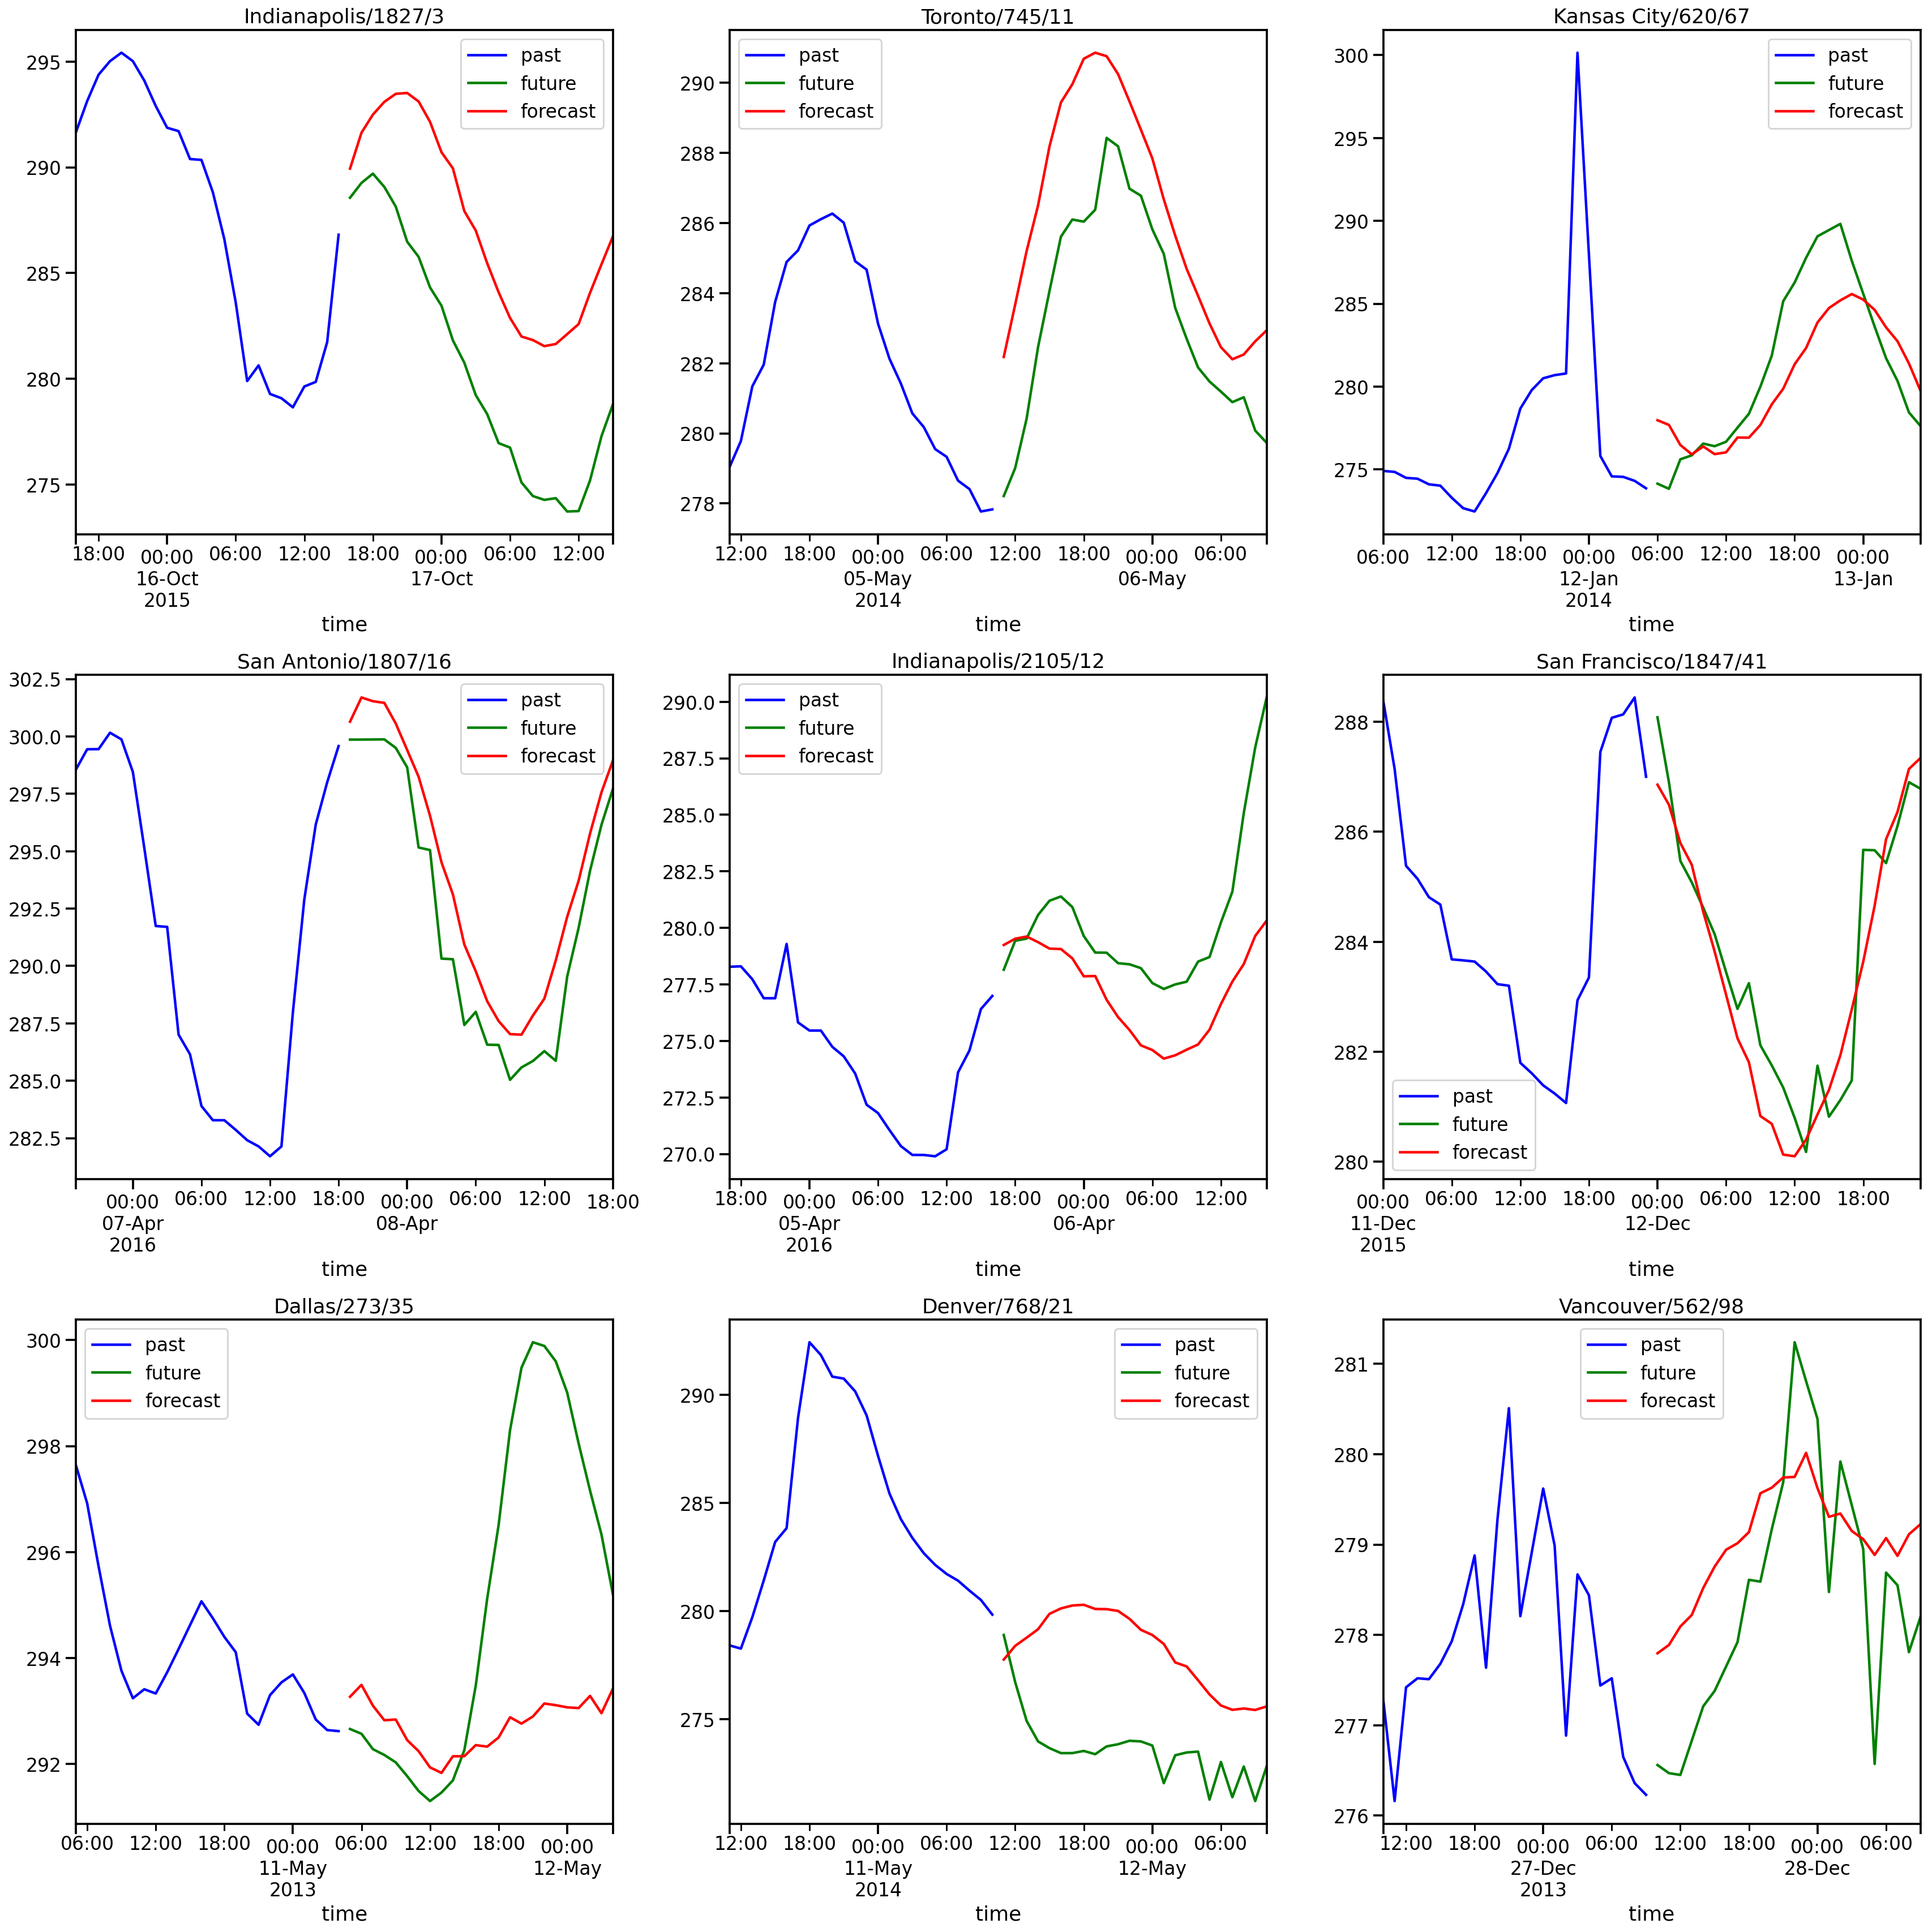

In [25]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat.rename(columns={'temperature': 'forecast'})
)

In [36]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the columns names.
# There was a similar example of this in the notebook from the first assignment.

score_y_hat.columns, score_y_hat.shape

(Index(['temperature'], dtype='object'), (57576, 1))

In [26]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

# Save model definition:
import json
with open(f'keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet('score_y_hat.parquet')